In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [2]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"
val_dir = "./dataset/val"

In [4]:
print("Train set:")
print("-"*60)
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("\nTest set:")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("\nValidation set")
print('-'*60)
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("./dataset/train/PNEUMONIA")
pneumonia_dir = "./dataset/train/PNEUMONIA"

Train set:
------------------------------------------------------------
PNEUMONIA=3876
NORMAL=1342

Test set:
------------------------------------------------------------
PNEUMONIA=390
NORMAL=234

Validation set
------------------------------------------------------------
PNEUMONIA=9
NORMAL=9


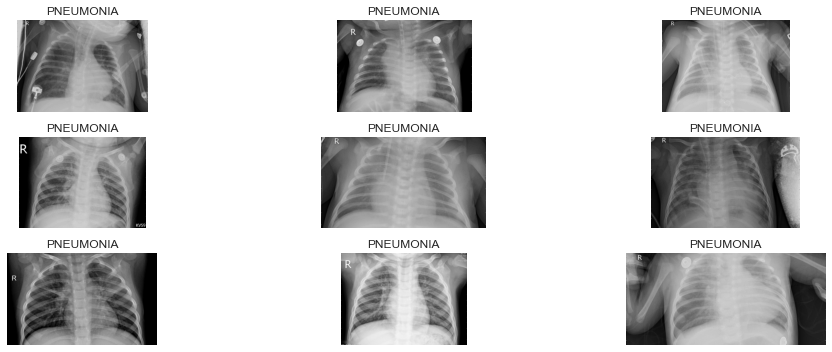

In [5]:
plt.figure(figsize=(15, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("PNEUMONIA")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    

plt.tight_layout()

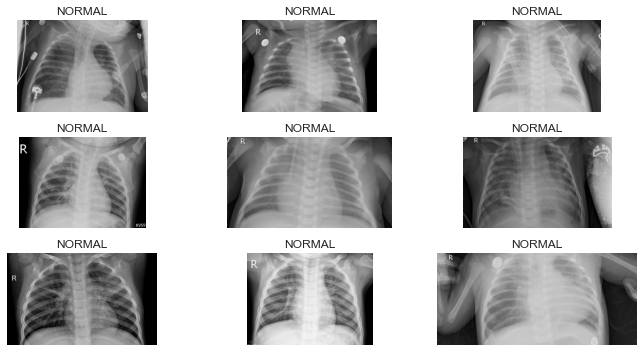

In [7]:
normal = os.listdir("./dataset/train/NORMAL")
normal_dir = "./dataset/train/NORMAL"

plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.title("NORMAL")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [8]:
import glob

pneumonia_train = glob.glob(train_dir+"/PNEUMONIA/*.jpeg")
normal_train = glob.glob(train_dir+"/NORMAL/*.jpeg")

data = pd.DataFrame(np.concatenate([[0]*len(normal_train) , [1]*len(pneumonia_train)]),columns=["class"])

In [9]:
data.head()


,class
0,0
1,0
2,0
3,0
4,0


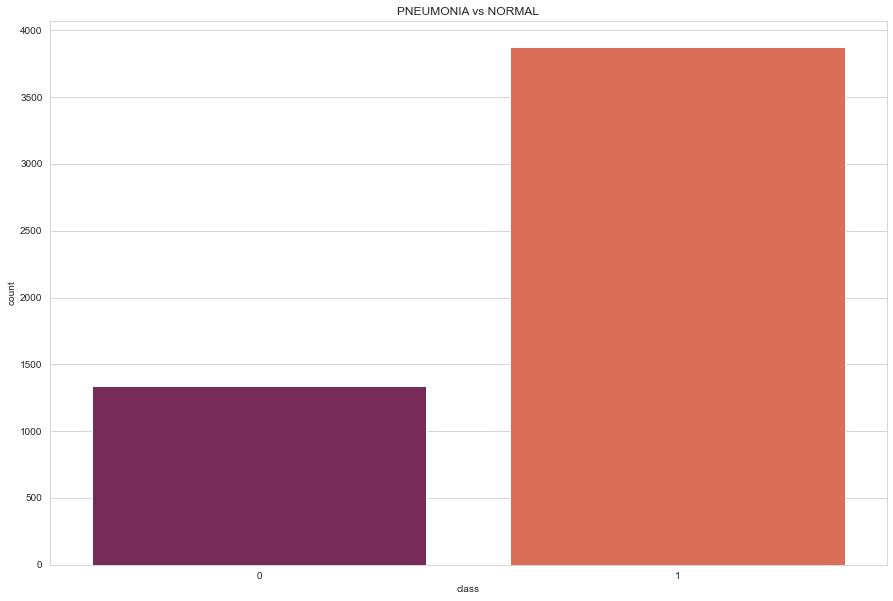

In [10]:
plt.figure(figsize=(15,10))
sns.countplot(data['class'],data=data,palette='rocket')
plt.title('PNEUMONIA vs NORMAL')
plt.show()

In [11]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [12]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',
#                                        target_size=(224,224,3))
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',
#                                               target_size=(224,224,3))
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',
#                                        target_size=(224/,224,3))
                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
img, label = next(train)


## VGG MODEL

In [14]:
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
#     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

2022-04-04 21:11:06.598998: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-04 21:11:06.600571: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


80142336/80134624 [==============================] - 9s 0us/step


In [15]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [17]:
history = model.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    )

2022-04-04 21:14:04.221988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 15 of 163
2022-04-04 21:14:14.213076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 163
2022-04-04 21:14:24.206296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 45 of 163
2022-04-04 21:14:34.048252: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 60 of 163
2022-04-04 21:14:44.276021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 75 of 163
2022-04-04 21:14:54.404120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 90 of 163
2022-04-04 21:15:04.461761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this 

Train for 100 steps, validate for 8 steps
Epoch 1/30


2022-04-04 21:15:55.227361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 15 of 163
2022-04-04 21:16:05.295984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 163
2022-04-04 21:16:15.572418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 45 of 163
2022-04-04 21:16:25.608056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 60 of 163
2022-04-04 21:16:35.057198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 74 of 163
2022-04-04 21:16:45.052876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 89 of 163
2022-04-04 21:16:55.024867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this 

  2/100 [..............................] - ETA: 2:55:21 - loss: 0.6220 - accuracy: 0.5938

In [ ]:
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

In [ ]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

## RESNET

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
resnet_model.trainable = True
print("Number of layers in the base model: ", len(resnet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
model2.summary()


In [ ]:
len(model2.trainable_variables)


In [ ]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model2.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

In [ ]:
score = model2.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')